In [2]:
import logging
import os.path as path
from dataclasses import dataclass

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch as t
import torch.nn.functional as F
from haikunator import Haikunator
from torch.utils.data import DataLoader

import torchutils as tu
from torchutils.metrics import rmse, mae

from datagen import gen_series, WindowedDataset

In [3]:
%matplotlib inline

In [4]:
EXPERIMENT_NAME = "TimeSeriesRNN2"
mlruns_dir = path.expanduser("~/mlruns")
mlflow.set_tracking_uri(mlruns_dir)

In [5]:
DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [6]:
logformat = "[%(levelname)s %(asctime)s] %(process)s-%(name)s: %(message)s"
logging.basicConfig(format=logformat, datefmt="%m-%d %I:%M:%S", level=logging.DEBUG)
logging.getLogger("git.cmd").setLevel(logging.WARN)
logging.getLogger("matplotlib").setLevel(logging.WARN)

In [7]:
(_, tp_series), _ = gen_series()
tp_ds = WindowedDataset(tp_series)
tp_ds.set_window_size(5+1)
tp_dl = DataLoader(tp_ds, batch_size=3, shuffle=True, drop_last=True)
tp_inputs, tp_targets = next(iter(tp_dl))
print(tp_inputs.shape, tp_targets.shape)

(1000,) (1000,)
(461,) (461,)
torch.Size([3, 5]) torch.Size([3])


In [8]:
tp_inputs_seq = tp_inputs.unsqueeze(2)

In [9]:
tp_inputs_seq.shape

torch.Size([3, 5, 1])

In [10]:
tp_inputs

tensor([[44.2535, 46.5786, 43.3510, 41.5148, 40.1775],
        [65.2623, 54.0231, 63.0076, 60.8455, 59.2596],
        [49.3527, 53.3147, 57.7118, 48.9344, 48.9312]])

In [11]:
tp_inputs_seq

tensor([[[44.2535],
         [46.5786],
         [43.3510],
         [41.5148],
         [40.1775]],

        [[65.2623],
         [54.0231],
         [63.0076],
         [60.8455],
         [59.2596]],

        [[49.3527],
         [53.3147],
         [57.7118],
         [48.9344],
         [48.9312]]])

In [12]:
class TimeSeriesRNN(t.nn.Module, tu.ModuleMixin):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.rnn = t.nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = t.nn.Linear(hidden_size, 1)

    def forward(self, batch_x):
        # input shape is batch_size x seq_len
        # need to convert it to batch_size x seq_len x 1
        # because each sequence is just a single number.
        x = batch_x.unsqueeze(2)

        # h_last shape is num_layers x batch_size x hidden_size
        # need to get the output of the topmost layer
        _, h_last = self.rnn(x)
        embedding = h_last[-1]

        batch_y_hat = self.fc(embedding)
        return t.squeeze(batch_y_hat, dim=1)


In [13]:
tp_model = TimeSeriesRNN(40, 2)

In [14]:
tp_outputs = tp_model(tp_inputs)

In [15]:
print(tp_targets.shape, tp_outputs.shape)

torch.Size([3]) torch.Size([3])


In [16]:
tp_x, tp_y = next(iter(tp_ds))
print(tp_x.shape, tp_y.shape)

(5,) ()


In [17]:
tp_y_hat = tp_model.predict(t.Tensor(tp_x))
tp_y_hat.shape

torch.Size([])

In [18]:
@dataclass
class MyHyperParams(tu.Hyperparams):
    window_size: int
    hidden_size: int
    num_layers: int
    batch_size: int
    n_epochs: int
    lr: float

In [19]:
def build_trainer(hparams, trainset, valset):
    run_name = Haikunator().haikunate()
    
    model = TimeSeriesRNN(hparams.hidden_size, hparams.num_layers)
    optim = t.optim.SGD(model.parameters(), lr=hparams.lr, momentum=0.9)
    loss_fn = t.nn.MSELoss(reduction="mean")
    
    trainset.set_window_size(hparams.window_size+1)
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True, drop_last=True)

    valset.set_window_size(hparams.window_size+1)
    valdl = DataLoader(valset, batch_size=461, shuffle=False)

    return tu.TrainerArgs(
        run_name=run_name,
        model=model,
        optim=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs=hparams.n_epochs,
        grad_warning_threshold=10_000,
        clip_grads=10_000
    )

In [20]:
(_, train_series), (_, val_series) = gen_series()
trainds = WindowedDataset(train_series)
valds = WindowedDataset(val_series)
hparams = MyHyperParams(
    window_size=20,
    hidden_size=40,
    num_layers=1,
    batch_size=32,
    n_epochs=100,
    lr=1e-4
)
model, model_path, metrics = tu.train(
    exp_name=EXPERIMENT_NAME,
    trainset=trainds,
    valset=valds,
    metrics=[rmse, mae],
    hparams=hparams,
    args_builder=build_trainer,
    log_frequency=10
)

[INFO 04-02 01:21:26] 2774-root: Experiment set to TimeSeriesRNN2


(1000,) (1000,)
(461,) (461,)
INFO: 'TimeSeriesRNN2' does not exist. Creating a new experiment


[INFO 04-02 01:21:39] 2774-root: Starting run misty-limit-6257
[INFO 04-02 01:21:40] 2774-root: Epoch 10: Train loss=187.434 Val loss=900.127
[INFO 04-02 01:21:42] 2774-root: Epoch 20: Train loss=111.255 Val loss=495.520
[INFO 04-02 01:21:43] 2774-root: Epoch 30: Train loss=184.456 Val loss=830.231
[INFO 04-02 01:21:45] 2774-root: Epoch 40: Train loss=174.586 Val loss=834.050
[INFO 04-02 01:21:46] 2774-root: Epoch 50: Train loss=232.460 Val loss=1020.581
[INFO 04-02 01:21:48] 2774-root: Epoch 60: Train loss=136.722 Val loss=509.326
[INFO 04-02 01:21:49] 2774-root: Epoch 70: Train loss=237.098 Val loss=1093.400
[INFO 04-02 01:21:50] 2774-root: Epoch 80: Train loss=333.013 Val loss=1368.207
[INFO 04-02 01:21:52] 2774-root: Epoch 90: Train loss=288.513 Val loss=1310.882
[INFO 04-02 01:21:53] 2774-root: Epoch 100: Train loss=168.183 Val loss=795.399
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container 

In [21]:
metrics

[28.202824, 25.016962]

In [22]:
def plot_series(times, *all_values):
    plt.figure(figsize=(15, 5))
    for values in all_values:
        plt.plot(times, values)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

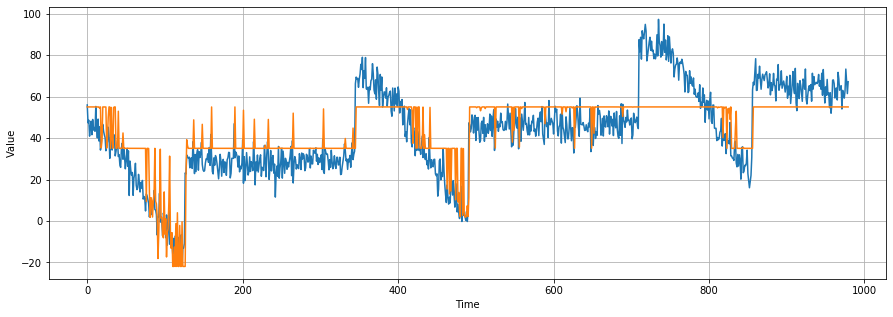

In [24]:
targets = []
outputs = []
for x, y in trainds:
    x = t.Tensor(x).to(DEVICE)
    y_hat = model.predict(x).detach().cpu().item()
    targets.append(y)
    outputs.append(y_hat)
targets = np.array(targets)
outputs = np.array(outputs)
plot_series(np.arange(len(targets)), targets, outputs)

In [25]:
tuner = tu.AutoTuner(
    exp_name="Tune" + EXPERIMENT_NAME, 
    trainset=trainds, 
    valset=valds, 
    obj_metric=rmse, 
    minimize=True
)

[INFO 04-02 01:22:32] 2774-root: Experiment set to TuneTimeSeriesRNN2


INFO: 'TuneTimeSeriesRNN2' does not exist. Creating a new experiment


In [26]:
hparams_spec = tu.HyperparamsSpec(
    factory=MyHyperParams,
    spec=[
        dict(name="window_size", type="range", value_type="int", bounds=[15, 100]),
        dict(name="hidden_size", type="range", value_type="int", bounds=[30, 50]),
        dict(name="num_layers", type="choice", value_type="int", values=[1, 2, 3]),
        dict(name="batch_size", type="choice", value_type="int", values=[8, 16, 32, 64, 128]),
        dict(name="n_epochs", type="range", value_type="int", bounds=[100, 1000]),
        dict(name="lr", type="range", bounds=[1e-9, 1e-4], log_scale=True)
    ]
)
tuner.tune(hparams_spec, build_trainer)

[INFO 04-02 01:22:39] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-02 01:22:39] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-02 01:22:39] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-02 01:22:39] 2774-root: Starting run purple-truth-0725
[INFO 04-02 01:23:52] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-02 01:23:52] 2774-root: Starting run empty-river-8788
[INFO 04-02 01:26:16] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-02 01:26:16] 2774-root: Starting run sparkling-darkness-7033
[INFO 04-02 01:27:25] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-02 01:27:25] 2774-root: Starting run falling-bread-1074
[INFO 04-02 01:31:06] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-02 01:31:06] 2774-root: Starting run icy-leaf-5062
[INFO 04-02 01:31:38] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-02 01:31:38] 2774-roo

In [27]:
model = tuner.best_model

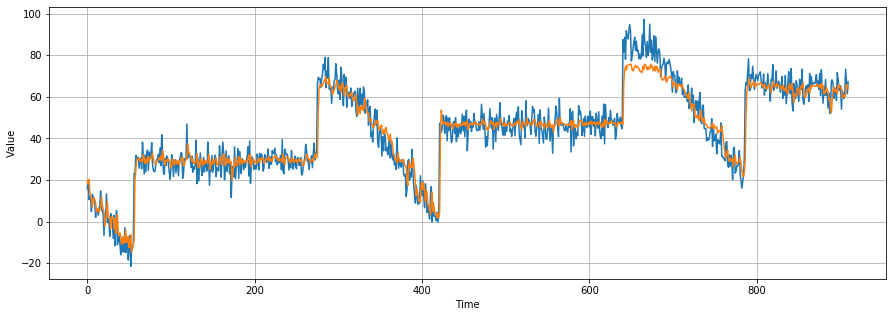

In [28]:
targets = []
outputs = []
for x, y in trainds:
    x = t.Tensor(x).to(DEVICE) 
    y_hat = model.predict(x).detach().cpu().item()
    targets.append(y)
    outputs.append(y_hat)
targets = np.array(targets)
outputs = np.array(outputs)
plot_series(np.arange(len(targets)), targets, outputs)